<div align="center">

<h1> Segmentation with YOLOv8<h1>
</div>

Image segmentation involves taking a lot of image inputs and generating an output which is a mask or a matrix with various elements that specify the object class or instance to which each pixel belongs. Many high-level image features, or heuristics, can be useful for image segmentation. These features are the basis for standard image segmentation algorithms, which use clustering algorithms such as edges and histograms.

<div align=""center">

<img width="1024" src="https://mindy-support.com/wp-content/webp-express/webp-images/doc-root/wp-content/uploads/2022/10/blog-11.jpg.webp">
</div>


## Medical Image Segmentation with YOLOv8
Medical image segmentation is a crucial process in many medical imaging applications.

It involves dividing or partitioning an image into multiple segments or “**regions of interest**” that correspond to different objects or parts of objects.

It processes visual data at the pixel level, using various techniques to annotate individual pixels as belonging to a specific class or instance

In the context of medical imaging, these could be various tissues, organs, cells, or anomalies like tumors.


### Importance of Medical Image Segmentation
Medical image segmentation plays a vital role in numerous biomedical applications, including:

1. **Disease Diagnosis and Monitoring**: It helps in the identification and visualization of anomalies or structures of interest in medical images, aiding in disease diagnosis and monitoring.
2. **Treatment Planning**: It provides critical information for planning treatment strategies, such as radiation therapy for cancer treatment.
3. **Computer-Aided Surgery**: It assists in pre-operative planning and
intra-operative navigation during surgical procedures.

### Applications of Medical Image Segmentation
1. **Tumor Detection**: It can help in the detection and localization of tumors in various parts of the body.
2. **Organ Delineation**: It can assist in delineating organs in medical images, which is crucial for surgical planning and organ transplantation.
3. **Blood Vessel Visualization**: It can aid in visualizing blood vessels in angiography images, which is essential for diagnosing and treating vascular diseases.
4. **Cell Counting and Classification**: It can help in counting and classifying cells in microscopic images, which is crucial in diagnosing diseases like cancer and monitoring treatment response.
5. **Fracture Identification**: It can assist in identifying and analyzing fractures, which is vital for treatment planning and monitoring the recovery process.

### YOLOv8 for Medical Image Segmentation
YOLOv8 (You Only Look Once version 8) is a state-of-the-art, real-time object detection system that can also be used for medical image segmentation. It can classify, detect, and segment objects in images, making it a versatile tool for medical image analysis.

Due to its high quality and real-time performance, YOLOv8 is highly effective when it comes to segmentation.


**Let's get started!**

## Installing necessary packages

In [1]:
#install packages
!pip install ultralytics &>1
print('Finished installing ultralytics')

#check if the GPU is enabled
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/78.2 GB disk)


In [2]:
#import packages

import os
import random
import torch
import pandas as pd
import zipfile
import urllib.request
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [3]:
## Set random seed for reproducibility
random.seed(2024) #42

## Loading the image data

Once you have loaded your pre-processed and augmented dataset from Roboflow, use the url to the dataset as shown in the image below.

<div align=""center">

<img width="1024" src="https://raw.githubusercontent.com/Marconi-Lab/dsa_2024/main/assets/download-ulr2.png">
</div>

In [4]:


url = "https://app.roboflow.com/ds/eHJfgHtWU6?key=oqtIXB35p3"


urllib.request.urlretrieve(url, "seg2.zip")

print("File downloaded successfully!")


File downloaded successfully!


In [5]:
#create a directory to save contents of the zip file
!mkdir seg2
!unzip seg2.zip -d data/

Archive:  seg2.zip
 extracting: data/README.dataset.txt  
 extracting: data/README.roboflow.txt  
 extracting: data/data.yaml          
   creating: data/test/
   creating: data/test/images/
 extracting: data/test/images/48_jpg.rf.84e3f13f4d70965ffd70fa0b1c6e42be.jpg  
 extracting: data/test/images/5_jpg.rf.b73e52a83456bf98cd02e104793d0326.jpg  
 extracting: data/test/images/61_jpg.rf.50ea7b8ecdd18e65d35bdf46d4935efe.jpg  
 extracting: data/test/images/7_jpg.rf.a5432c2b1ba85379e5b963c23b32a5ee.jpg  
 extracting: data/test/images/80_jpg.rf.d65c4f383e3b3f61e996dbc033e403fa.jpg  
 extracting: data/test/images/84_jpg.rf.f093ba6457de336c968eba617d56fc12.jpg  
 extracting: data/test/images/8_jpg.rf.09b0688a8ff9fc302b5dbacdc7157774.jpg  
 extracting: data/test/images/93_jpg.rf.9916236e540f1f4db758dacbe94110b8.jpg  
 extracting: data/test/images/96_jpg.rf.fccf27574d26a97f5f5df8c071bc79c8.jpg  
 extracting: data/test/images/98_jpg.rf.4e609a990d4b4c5243eedb49539e0da7.jpg  
   creating: data/test

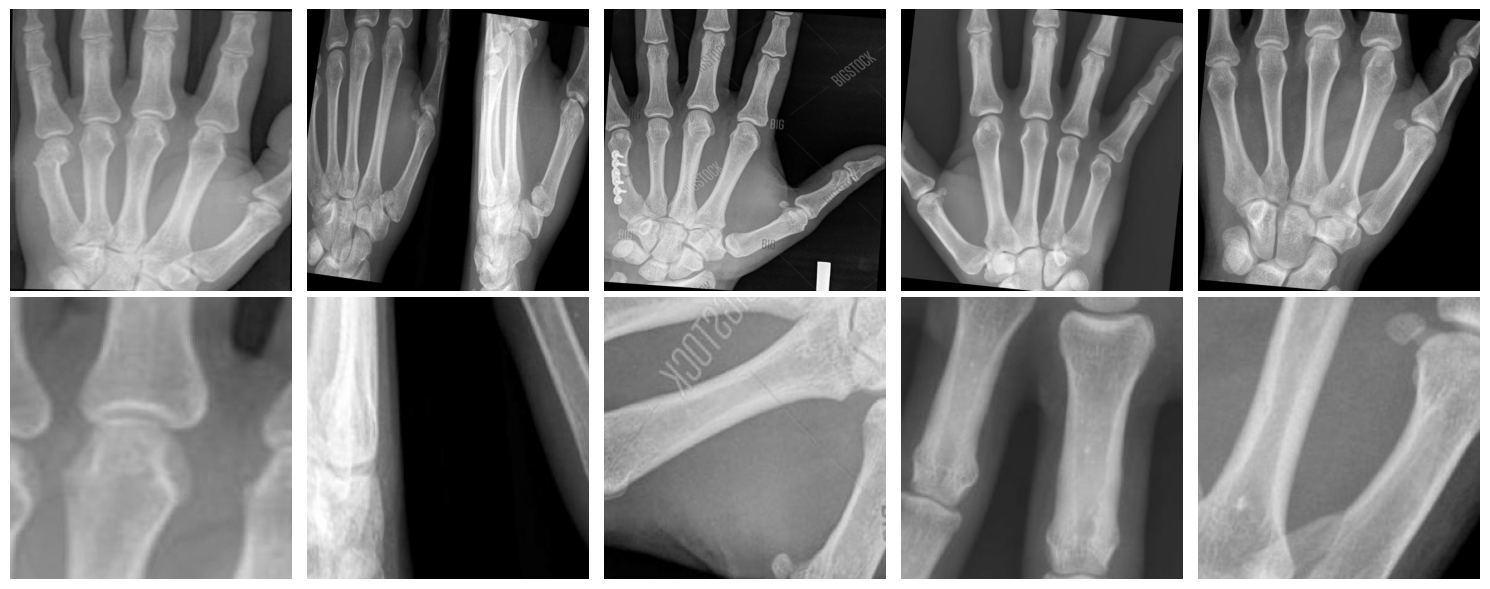

In [7]:
import albumentations as A

# Define the augmentation transforms
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.RandomCrop(224,224)
])

# Plot the random images without labels and after segmentation
plt.figure(figsize=(15, 6))
for i, image_name in enumerate(random_images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))

    # Read the image
    image = plt.imread(image_path)

    # Apply augmentation transforms
    augmented = transform(image=image)
    augmented_image = augmented["image"]

    # Plot the original image without labels
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.axis('off')

    # Plot the augmented image after segmentation
    plt.subplot(2, 5, i+6)
    plt.imshow(augmented_image)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Zero Shot Learning
Zero-Shot Learning (ZSL) is particularly relevant to image segmentation, including medical image segmentation. In traditional segmentation models, the model is trained to recognize and segment specific classes or categories present in the training data. However, these models may struggle when encountering new classes not seen during training.

This is where ZSL comes into play. In the context of segmentation, Zero-Shot Segmentation models are trained in such a way that they can segment objects or classes they have never seen before during training. This is achieved by leveraging auxiliary information that associates observed and non-observed classes.

###  Loading and Using the YOLOv8 Segmentation Model with Zero-Shot Learning

In this section, we will load the YOLOv8 segmentation model, which is capable of Zero-Shot Learning (ZSL). We will use it to perform segmentation on an image, including classes that the model has not seen during training. Finally, we will visualize the segmentation results.

Using device: cuda


100%|██████████| 6.73M/6.73M [00:00<00:00, 127MB/s]



image 1/1 /content/data/train/images/0_jpg.rf.301f9bcfb4a4f2bbb68650892f14db3e.jpg: 640x640 1 person, 12.6ms
Speed: 3.9ms preprocess, 12.6ms inference, 5783.2ms postprocess per image at shape (1, 3, 640, 640)


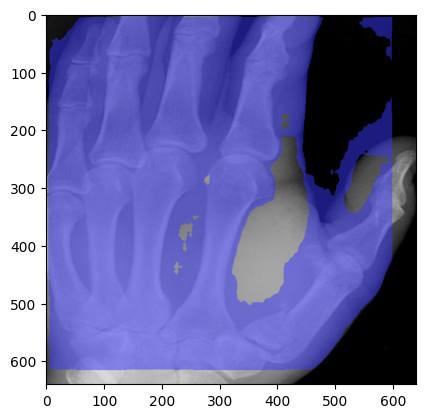

In [8]:
os.environ['WANDB_MODE'] = 'disabled'

# Check for CUDA device and set it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')


# Load YOLOv8 segmentation model.nano
model = YOLO('yolov8n-seg.pt').to(device)

# Get the path of the image
image_path = "/content/data/train/images/0_jpg.rf.301f9bcfb4a4f2bbb68650892f14db3e.jpg"

# Perform segmentation on the image
results = model(image_path)

# Visualize the results
plt.imshow(results[0].plot(boxes=False))
plt.show()


### Exercise

Try doing zero shot segmentation for various YOLOv8 segmentation variants and note the differences i.e small, medium, large and extra large

In [9]:
#TO DO:


### Fine-Tuning the YOLOv8 Segmentation Model
In this section, we will fine-tune the YOLOv8 segmentation model. Fine-tuning involves training a pre-existing model (a process also known as transfer learning) on a new task. It leverages the learned feature representations of the original model, which can lead to significant improvements in performance, especially when the new task is similar to the original one.

In [10]:
# Load YOLOv8 segmentation model.nano
model = YOLO('yolov8n-seg.pt').to(device)
training = model.train(data='/content/data/data.yaml', epochs=50, imgsz=256, batch=8)

engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/data/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=256, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=F

100%|██████████| 755k/755k [00:00<00:00, 23.2MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 61.9MB/s]


AMP: checks passed ✅


train: Scanning /content/data/train/labels... 432 images, 4 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<00:00, 1388.08it/s]

train: WARNING ⚠️ /content/data/train/images/112_jpg.rf.e55b6d48cbe88abded5d749855f194bd.jpg: 1 duplicate labels removed
train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/data/valid/labels... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<00:00, 831.58it/s]

val: New cache created: /content/data/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.617G      1.547      2.788      3.109      1.355        174        256: 100%|██████████| 54/54 [00:26<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         26        206      0.827      0.208      0.301      0.187      0.827      0.208      0.304      0.201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.564G      1.164      1.726      1.754       1.07         69        256: 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         26        206      0.308      0.568      0.315      0.219      0.304       0.54      0.331       0.21



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.558G      1.099      1.651      1.491      1.046         96        256: 100%|██████████| 54/54 [00:21<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all         26        206      0.277      0.649      0.377       0.25      0.275      0.643      0.362      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.558G      1.036      1.525      1.394       1.03        101        256: 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         26        206      0.348      0.557      0.373       0.28      0.344      0.568      0.371      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.558G     0.9632      1.539      1.297      1.006        134        256: 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         26        206      0.317       0.59      0.371       0.28      0.312      0.568      0.367      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.537G     0.9597      1.451      1.282      1.007        158        256: 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         26        206      0.383      0.706      0.433      0.312      0.379      0.637      0.426      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.556G     0.8711      1.346      1.178     0.9863        144        256: 100%|██████████| 54/54 [00:20<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         26        206      0.328      0.623      0.423      0.311      0.328      0.617      0.417      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.577G     0.8881      1.282      1.179     0.9815        125        256: 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         26        206      0.338      0.601      0.436      0.339      0.342      0.596      0.431      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.535G     0.8739      1.302      1.188     0.9833         59        256: 100%|██████████| 54/54 [00:19<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         26        206      0.395      0.683      0.479      0.346        0.4      0.626      0.466      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.537G     0.8487      1.242      1.129      0.974        102        256: 100%|██████████| 54/54 [00:19<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         26        206      0.576      0.565      0.461      0.347      0.547      0.536      0.428      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      0.65G     0.8167      1.243      1.084      0.963         98        256: 100%|██████████| 54/54 [00:24<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         26        206      0.453      0.665      0.515       0.39      0.564      0.565      0.498      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.535G     0.8332      1.294      1.116     0.9667        108        256: 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         26        206        0.4      0.719      0.447       0.34      0.399       0.72       0.45      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.558G     0.8297      1.216      1.089     0.9595        113        256: 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         26        206      0.449      0.612      0.454      0.351      0.443      0.604       0.45      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.535G     0.8047      1.194      1.096     0.9596        162        256: 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         26        206      0.481      0.633      0.487      0.366      0.457      0.616      0.463      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.516G     0.8146      1.196      1.103     0.9664         91        256: 100%|██████████| 54/54 [00:19<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         26        206      0.433      0.661       0.44      0.342      0.409      0.614      0.419      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.535G     0.8252      1.249      1.073     0.9615        104        256: 100%|██████████| 54/54 [00:19<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         26        206      0.492      0.593      0.514      0.397      0.508      0.568      0.503      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.579G     0.7801      1.156      1.052     0.9411        115        256: 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         26        206      0.443      0.581       0.46      0.327      0.423       0.59      0.438      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.537G     0.7848      1.194      1.017      0.953         97        256: 100%|██████████| 54/54 [00:20<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         26        206      0.502      0.651      0.507      0.405      0.502      0.651      0.502       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.535G     0.7823      1.103      1.025     0.9396        140        256: 100%|██████████| 54/54 [00:20<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         26        206      0.488      0.503      0.501      0.412      0.488      0.503      0.496      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.556G     0.7806      1.125      1.023     0.9468         95        256: 100%|██████████| 54/54 [00:20<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         26        206      0.476      0.662        0.5      0.396      0.502      0.626      0.496      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.535G     0.7572      1.135       1.05      0.934         91        256: 100%|██████████| 54/54 [00:19<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         26        206      0.496      0.681      0.492      0.402      0.489      0.665      0.489       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.535G     0.7597      1.084     0.9884     0.9288         73        256: 100%|██████████| 54/54 [00:20<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

                   all         26        206      0.588      0.604      0.557      0.443      0.553      0.607      0.535      0.405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.535G     0.7427      1.072      1.005     0.9297        108        256: 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         26        206      0.424      0.704      0.459      0.363      0.437      0.629      0.464      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.556G      0.755      1.121     0.9708     0.9358        146        256: 100%|██████████| 54/54 [00:19<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

                   all         26        206      0.483      0.564      0.513      0.416      0.483      0.564      0.508      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.535G     0.7351      1.073     0.9678     0.9317        121        256: 100%|██████████| 54/54 [00:20<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         26        206      0.486      0.652      0.493      0.392      0.479      0.653      0.483      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.556G      0.723      1.048      0.947     0.9231        195        256: 100%|██████████| 54/54 [00:20<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

                   all         26        206      0.546      0.642      0.547      0.429      0.544      0.623      0.531      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      0.65G     0.7107      1.078     0.9371     0.9263         88        256: 100%|██████████| 54/54 [00:19<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         26        206      0.552      0.606      0.557      0.424      0.528      0.587      0.526      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.554G     0.7312       1.03     0.9148     0.9176        139        256: 100%|██████████| 54/54 [00:20<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         26        206      0.511      0.655      0.527      0.421      0.522      0.663      0.528      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.537G     0.7251      1.059     0.9443     0.9281        115        256: 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         26        206      0.413      0.668      0.476      0.379        0.4      0.664      0.466       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.535G     0.6985      1.052     0.8935     0.9105        117        256: 100%|██████████| 54/54 [00:20<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         26        206      0.486      0.473       0.42      0.333      0.509       0.49      0.429      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.556G     0.6946      1.009     0.9201      0.917        138        256: 100%|██████████| 54/54 [00:20<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         26        206      0.495      0.669      0.535      0.425      0.432      0.714      0.521      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.535G     0.7081       1.02     0.8836     0.9202         97        256: 100%|██████████| 54/54 [00:20<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         26        206      0.557      0.581      0.507      0.405      0.554      0.579      0.501      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.556G     0.6893     0.9581     0.8599     0.9113        104        256: 100%|██████████| 54/54 [00:20<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         26        206      0.549      0.664      0.493      0.393      0.549      0.664      0.498      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.556G     0.6775     0.9936     0.8373     0.9075        116        256: 100%|██████████| 54/54 [00:20<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         26        206      0.508      0.752      0.534      0.415      0.506       0.75      0.521      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.535G     0.6879     0.9929     0.8662     0.9201        100        256: 100%|██████████| 54/54 [00:20<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         26        206      0.395      0.591      0.419      0.319      0.376      0.573      0.405      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.556G     0.6927      1.001     0.8578     0.9051        174        256: 100%|██████████| 54/54 [00:19<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         26        206      0.445      0.542       0.42      0.319      0.445      0.542      0.416      0.284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.535G     0.6722      0.966     0.8392     0.9084        130        256: 100%|██████████| 54/54 [00:19<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         26        206      0.481      0.647       0.47       0.36       0.46      0.628      0.442      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.556G     0.6931     0.9896      0.902     0.9139        119        256: 100%|██████████| 54/54 [00:20<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         26        206      0.506      0.506      0.443      0.352      0.482      0.484      0.427      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.537G     0.6813     0.9588      0.876     0.9093         48        256: 100%|██████████| 54/54 [00:20<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         26        206      0.466      0.506      0.437      0.336      0.454      0.483      0.421      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.652G     0.6686     0.9467     0.8439     0.9118         93        256: 100%|██████████| 54/54 [00:20<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         26        206      0.385       0.57        0.4      0.307      0.389      0.589       0.39      0.272


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.531G     0.6414     0.9115      0.827     0.8957         56        256: 100%|██████████| 54/54 [00:15<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         26        206       0.42      0.675      0.416       0.33      0.414      0.649      0.409      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.648G     0.6354     0.9095      0.806        0.9         47        256: 100%|██████████| 54/54 [00:11<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         26        206      0.468      0.738      0.494      0.369      0.459      0.697      0.483      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      0.51G     0.6137     0.8876     0.7825     0.9055         73        256: 100%|██████████| 54/54 [00:08<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         26        206      0.419      0.643      0.419      0.321      0.409      0.661       0.42      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.533G     0.5915     0.8497     0.7202     0.8924         81        256: 100%|██████████| 54/54 [00:12<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         26        206      0.435      0.691      0.466      0.364      0.445       0.71      0.468      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.533G     0.5983     0.8524     0.7202     0.8989         67        256: 100%|██████████| 54/54 [00:09<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         26        206      0.441      0.686      0.466      0.354      0.431      0.688      0.465      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.512G     0.5968     0.8469      0.702     0.8854         86        256: 100%|██████████| 54/54 [00:10<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         26        206       0.44      0.726      0.471      0.371      0.445      0.644      0.465      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.512G     0.5727     0.8262     0.7004     0.8806         79        256: 100%|██████████| 54/54 [00:11<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         26        206      0.407      0.686      0.435      0.338      0.405      0.683       0.43      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.531G     0.5924     0.8496     0.7717     0.8826         91        256: 100%|██████████| 54/54 [00:08<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         26        206      0.396       0.57      0.398      0.303      0.369      0.644      0.391      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      0.51G      0.572      0.845     0.6843     0.8808         53        256: 100%|██████████| 54/54 [00:11<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         26        206      0.428       0.76      0.441      0.339      0.408      0.727      0.429        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.512G     0.5701      0.814     0.6695     0.8846         98        256: 100%|██████████| 54/54 [00:10<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         26        206      0.416      0.707      0.428      0.331      0.402      0.683       0.42       0.29



50 epochs completed in 0.274 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.7MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.7MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


                   all         26        206      0.588      0.604      0.557      0.443      0.554      0.607      0.535      0.404
                     -         26        180      0.667      0.889      0.754      0.624       0.66      0.907      0.754      0.565
seg-2-full- - v10 2023-11-20 2-59pm         26         26      0.509      0.319       0.36      0.262      0.447      0.308      0.315      0.243
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/train


### Image Inference
Now that we've trained our model, it's time to put it to the test! We'll select the best performing model and use it to run inference on a set of images.

In [23]:
model.val()

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/data/valid/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


                   all         26        206       0.59      0.606      0.557      0.442      0.552      0.607      0.534      0.405
                     -         26        180      0.667      0.889      0.754      0.622       0.66      0.907      0.753      0.566
seg-2-full- - v10 2023-11-20 2-59pm         26         26      0.512      0.323      0.359      0.262      0.445      0.308      0.316      0.243
Speed: 0.1ms preprocess, 30.2ms inference, 0.0ms loss, 10.7ms postprocess per image
Results saved to runs/segment/train5


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cbf160406d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

In [34]:
!wget https://raw.githubusercontent.com/Marconi-Lab/dsa_2024/main/assets/multiple_fractures.jpg -d multiple_fractures.jpg

sample_test_image = '/content/multiple_fractures.jpg'

#make prediction on a sample image with multiple fractures
results = model.predict(sample_test_image)




DEBUG output created by Wget 1.21.2 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'multiple_fractures.jpg' (UTF-8) -> 'multiple_fractures.jpg' (UTF-8)
--2024-05-17 14:45:55--  https://raw.githubusercontent.com/Marconi-Lab/dsa_2024/main/assets/multiple_fractures.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Caching raw.githubusercontent.com => 185.199.108.133 185.199.109.133 185.199.110.133 185.199.111.133 2606:50c0:8001::154 2606:50c0:8003::154 2606:50c0:8000::154 2606:50c0:8002::154
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
Created socket 3.
Releasing 0x0000564e8998c050 (new refcount 1).
Initiating SSL handshake.
Handshake successful; connected socket 3 to SSL handle 0x0000564e8998dc40
certificate:
  subject: CN=*.github.io,O=GitHub\\, Inc.,L=San Francisco,ST=California,C=US
  issuer:  CN=Dig

In [ ]:
#save results
os.makedirs('test_results', exist_ok=True)
for result in results:
  result_path = os.path.join('test_results', os.path.basename(result.path))
  result.save(result_path)

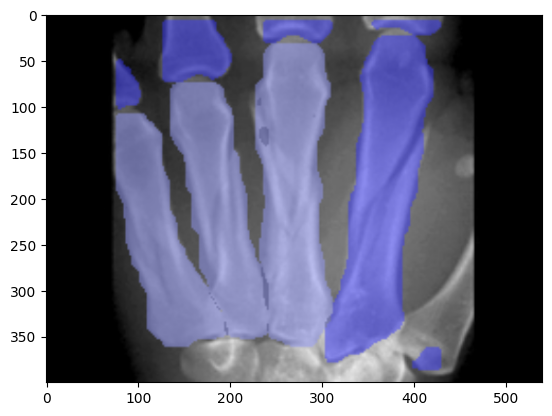

In [35]:

# Visualize the results
plt.imshow(results[0].plot(boxes=False))
plt.show()

                         epoch           train/box_loss  \
count                 50.00000                50.000000   
mean                  25.50000                 0.769802   
std                   14.57738                 0.172425   
min                    1.00000                 0.570060   
25%                   13.25000                 0.678432   
50%                   25.50000                 0.733150   
75%                   37.75000                 0.823037   
max                   50.00000                 1.547000   

                train/seg_loss           train/cls_loss  \
count                50.000000                50.000000   
mean                  1.140068                 1.027304   
std                   0.318950                 0.368078   
min                   0.813970                 0.669510   
25%                   0.960608                 0.847407   
50%                   1.072650                 0.957375   
75%                   1.235525                 1.094150

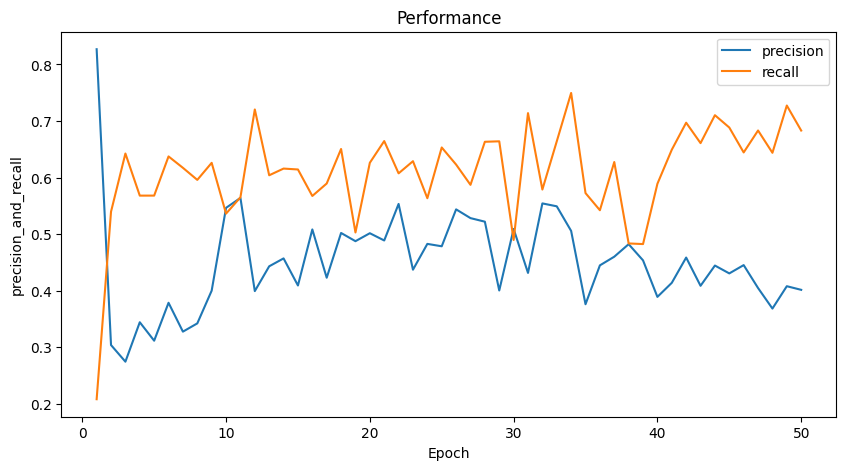

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your results file
df = pd.read_csv('/content/runs/segment/train/results.csv')

print(df.describe())

# Plotting the mAP value
plt.figure(figsize=(10, 5))

plt.plot(df['                  epoch'], df['   metrics/precision(M)'], label='precision')
plt.plot(df['                  epoch'], df['      metrics/recall(M)'], label='recall')


plt.xlabel('Epoch')
plt.ylabel('precision_and_recall')
plt.title('Performance')
plt.legend()
plt.show()

In [13]:
df.columns


Index(['                  epoch', '         train/box_loss',
       '         train/seg_loss', '         train/cls_loss',
       '         train/dfl_loss', '   metrics/precision(B)',
       '      metrics/recall(B)', '       metrics/mAP50(B)',
       '    metrics/mAP50-95(B)', '   metrics/precision(M)',
       '      metrics/recall(M)', '       metrics/mAP50(M)',
       '    metrics/mAP50-95(M)', '           val/box_loss',
       '           val/seg_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')

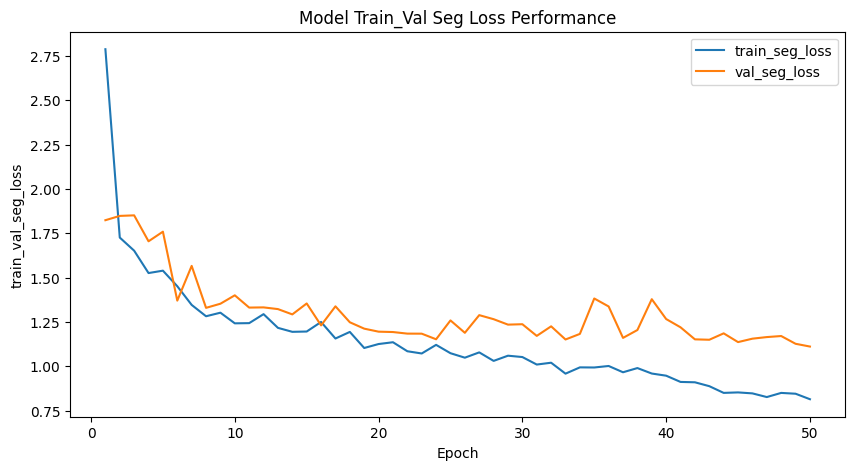

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(df['                  epoch'], df['         train/seg_loss'], label='train_seg_loss')
plt.plot(df['                  epoch'], df['           val/seg_loss'], label='val_seg_loss')
plt.xlabel('Epoch')
plt.ylabel('train_val_seg_loss')
plt.title('Model Train_Val Seg Loss Performance')
plt.legend()
plt.show()

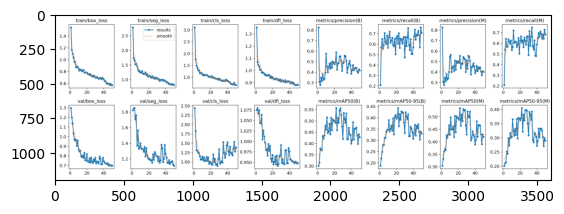

In [15]:
plt.imshow(plt.imread("/content/runs/segment/train/results.png"))

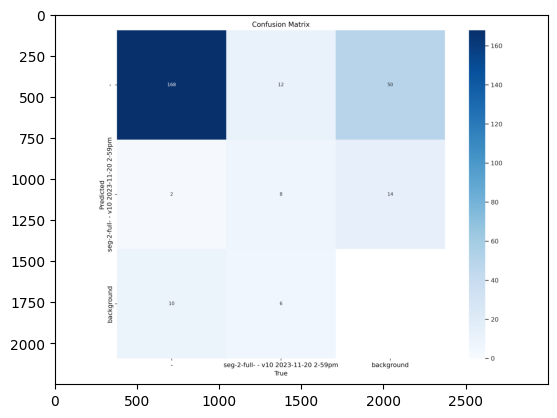

In [16]:
plt.imshow(plt.imread("/content/runs/segment/train/confusion_matrix.png"))

# Exercise: Exploring YOLOv8 Segmentation Variants

In this exercise, you will experiment with different YOLOv8 segmentation variants, batch sizes, and epochs to observe their effects on the segmentation results.

1. **Segmentation Variants**: Try using different YOLOv8 segmentation variants such as 'yolov8s-seg', 'yolov8m-seg', 'yolov8l-seg', and 'yolov8x-seg'. Observe how the size and complexity of the model affect the segmentation results and computation time.

2. **Batch Sizes**: Experiment with different batch sizes. Start with a small batch size (e.g., 2 or 4), and gradually increase it (e.g., 8, 16, 32). Note how the batch size impacts the training speed and memory usage.

3. **Epochs**: Vary the number of epochs for training. Begin with a small number of epochs (e.g., 5 or 10) and gradually increase it (e.g., 20, 50, 100). Observe how the number of epochs affects the model's performance and overfitting.

Remember to record your observations and findings. This will help you understand the trade-offs involved and make informed decisions when fine-tuning models for your specific tasks. Happy experimenting!


In [17]:
#To do.